# Create some arch from scratch

In [42]:
import torch
import torchaudio
from torch import nn
from torch.nn import functional as F
import numpy as np

In [43]:
import sys
sys.path.append('../')

In [49]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

def plot_wave(y, sr=1600, figsize=(10, 2)):
    librosa.display.waveshow(np.array(y), sr=sr)

In [18]:
import yaml
from addict import Dict
def load_config(cfg):
    with open(cfg) as f:
        config = yaml.load(f, Loader=yaml.FullLoader)
    return Dict(config)

In [24]:
config = load_config('../configs/demucs_config.yaml')
config.dataset.train.ann_path = '../dataset/train.txt'
config.dataset.val.ann_path = '../dataset/val.txt'
config.dataset.test.ann_path = '../dataset/test.txt'

In [29]:
from src.dataset import get_train_val_test_loaders
train_loader, _, _ = get_train_val_test_loaders(config.dataset)

In [32]:
for noisy, clean, _ in train_loader:
    break

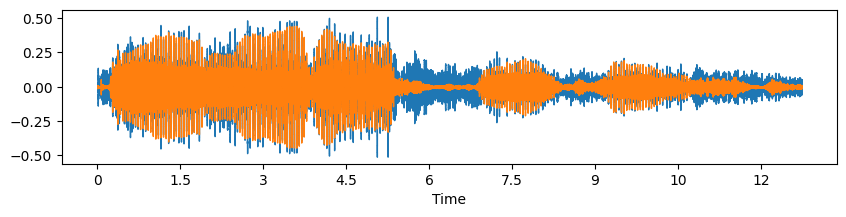

In [50]:
plt.figure(figsize=(10, 2))

plot_wave(noisy[0])
plot_wave(clean[0])

# Basic Conv

In [51]:
class BasicConv(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size=3,
                 stride=1,
                 padding=1,
                 bias=True,
                 activation=nn.PReLU()):
        super(BasicConv, self).__init__()
        self.conv = nn.Conv1d(
            in_channels, out_channels,
            kernel_size=kernel_size,
            stride=stride, padding=padding,
            bias=bias
        )
        self.bn = nn.BatchNorm1d(out_channels)
        self.activation = activation
        

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.activation(x)
        return x

In [52]:
class BasicDeConv(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size=3,
                 stride=1,
                 padding=1,
                 bias=True,
                 activation=nn.PReLU()):
        super(BasicDeConv, self).__init__()
        self.deconv = nn.ConvTranspose1d(
            in_channels, out_channels,
            kernel_size=kernel_size,
            stride=stride, padding=padding,
            bias=bias
        )
        self.bn = nn.BatchNorm1d(out_channels)
        self.activation = activation
        

    def forward(self, x):
        x = self.deconv(x)
        x = self.bn(x)
        x = self.activation(x)
        return x

# Gated Conv

In [53]:
class GatedConv(nn.Module):

    def __init__(self,
                in_channels, out_channels,
                kernel_size=3, stride=1, padding=1,
                dilation=1, groups=1, bias=True,
                batch_norm=True,
                activation=nn.LeakyReLU(0.2, inplace=True)):
        super(GatedConv, self).__init__()
        self.batch_norm = batch_norm
        self.activation = activation
        self.conv = nn.Conv1d(
                in_channels, out_channels,
                kernel_size=kernel_size,
                stride=stride, padding=padding,
            
                bias=bias
            )
        self.mask_conv = nn.Conv1d(
                in_channels, out_channels,
                kernel_size=kernel_size,
                stride=stride, padding=padding,
                bias=bias
            )
        self.batch_norm = nn.BatchNorm1d(out_channels)
        self.sigmoid = nn.Sigmoid()

        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight)
    
    def gated(self, mask):
        return self.sigmoid(mask)

    def forward(self, input):
        x = self.conv(input)
        mask = self.mask_conv(input)
        x = x * self.gated(mask)
        x = self.batch_norm(x)
        return x

In [54]:
class GatedDeConv(nn.Module):

    def __init__(self,
                in_channels, out_channels,
                kernel_size=3, stride=1, padding=1,
                dilation=1, groups=1, bias=True,
                batch_norm=True,
                activation=nn.LeakyReLU(0.2, inplace=True)):
        super(GatedDeConv, self).__init__()
        self.batch_norm = batch_norm
        self.activation = activation
        self.deconv = nn.ConvTranspose1d(
                in_channels, out_channels,
                kernel_size=kernel_size,
                stride=stride, padding=padding,
                bias=bias
            )
        self.mask_deconv = nn.ConvTranspose1d(
                in_channels, out_channels,
                kernel_size=kernel_size,
                stride=stride, padding=padding,
                bias=bias
            )
        self.batch_norm = nn.BatchNorm1d(out_channels)
        self.sigmoid = nn.Sigmoid()

        for m in self.modules():
            if isinstance(m, nn.ConvTranspose1d):
                nn.init.kaiming_normal_(m.weight)
    
    def gated(self, mask):
        return self.sigmoid(mask)

    def forward(self, input):
        x = self.deconv(input)
        mask = self.mask_deconv(input)
        x = x * self.gated(mask)
        x = self.batch_norm(x)
        return x

In [56]:
import math

class GateWave(nn.Module):
    def __init__(self,
                 depth=3, scale=2, init_hidden=32,
                 kernel_size=7, stride=1, padding=2,
                 encoder_class=BasicConv,
                 decoder_class=BasicDeConv):
        super(GateWave, self).__init__()
        self.depth = depth
        self.kernel_size = kernel_size
        self.stride = stride
        in_channels = 1
        out_channels = 1
        encoders = []
        decoders = []
        
        hidden = init_hidden
        in_ch = in_channels
        for i in range(depth):
            
            encoder = encoder_class(in_channels, hidden, kernel_size, stride, padding)
            encoders.append(encoder)
            
            decoder = decoder_class(hidden, out_channels, kernel_size, stride, padding)
            decoders.append(decoder)
            out_channels = hidden
            in_channels = hidden
            hidden = int(hidden * scale)
            
            
        self.encoder = nn.Sequential(*encoders)
        self.decoder = nn.Sequential(*decoders[::-1])
    
    def valid_length(self, length):
        """
        Return the nearest valid length to use with the model so that
        there is no time steps left over in a convolutions, e.g. for all
        layers, size of the input - kernel_size % stride = 0.
        If the mixture has a valid length, the estimated sources
        will have exactly the same length.
        """
#         length = math.ceil(length * self.resample)
        for idx in range(self.depth):
            length = math.ceil((length - self.kernel_size) / self.stride) + 1
            length = max(length, 1)
        for idx in range(self.depth):
            length = (length - 1) * self.stride + self.kernel_size
#         length = int(math.ceil(length / self.resample))
        return int(length)
    
    
    def forward(self, x):
        length = x.shape[-1]
        x = F.pad(x, (0, self.valid_length(length) - length))
        latent = self.encoder(x)
        output = self.decoder(latent)
        return output

In [70]:
def stft(x, fft_size, hop_size, win_length, window):
    """Perform STFT and convert to magnitude spectrogram.
    Args:
        x (Tensor): Input signal tensor (B, T).
        fft_size (int): FFT size.
        hop_size (int): Hop size.
        win_length (int): Window length.
        window (str): Window function type.
    Returns:
        Tensor: Magnitude spectrogram (B, #frames, fft_size // 2 + 1).
    """
    x_stft = torch.view_as_real(
        torch.stft(
            x, fft_size, hop_size, win_length, window, return_complex=True
        )
    )
    real = x_stft[..., 0]
    imag = x_stft[..., 1]

    return torch.sqrt(torch.clamp(real**2 + imag**2, min=1e-7)).transpose(2, 1)

In [71]:
class STFTLoss(torch.nn.Module):
    def __init__(
        self, fft_size=1024, shift_size=120, win_length=600, window="hann_window"
    ):
        """Initialize STFT loss module."""
        super(STFTLoss, self).__init__()
        self.fft_size = fft_size
        self.shift_size = shift_size
        self.win_length = win_length
        self.register_buffer("window", getattr(torch, window)(win_length))

    def forward(self, x, y):
        """Calculate forward propagation.
        Args:
            x (Tensor): Predicted signal (B, T).
            y (Tensor): Groundtruth signal (B, T).
        Returns:
            Tensor: Spectral convergence loss value.
            Tensor: Log STFT magnitude loss value.
        """
        x_mag = stft(x, self.fft_size, self.shift_size, self.win_length, self.window)
        y_mag = stft(y, self.fft_size, self.shift_size, self.win_length, self.window)
        sc_loss = torch.norm(y_mag - x_mag, p="fro") / torch.norm(y_mag, p="fro")
        mag_loss = F.l1_loss(torch.log(y_mag), torch.log(x_mag))
        return sc_loss + mag_loss

In [72]:
STFT = STFTLoss()
def loss_fn(x, y):
    return STFT(x, y) + F.l1_loss(x, y)

In [57]:
model = GateWave(encoder_class=GatedConv, decoder_class=GatedDeConv)

In [58]:
out = model(noisy)

In [84]:
pred = model(noisy)
l = loss_fn(clean[:,0,:], out[:,0,:])

In [82]:
l

tensor(5.8754, grad_fn=<AddBackward0>)